# Task6

Necessary imports:

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Calibration


### Speed calibration 

Average calibration speed: 5.5101 cm/s
Calibration speed variance : 0.467895 


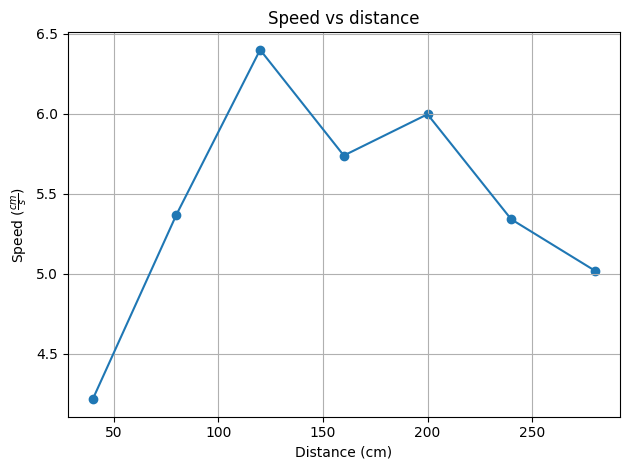

In [14]:


data_speed_calibration = np.loadtxt('../data/task4/robot_speed_task4.csv', delimiter=',', dtype='double')
distance_marks_cm = data_speed_calibration[:,0] # to meters
t_n = data_speed_calibration[:,1]
speeds = np.zeros(len(t_n))

for i,tn in enumerate(t_n):
    if(i==0):
        speeds[i] = distance_marks_cm[i]/tn
    else:
        speeds[i] = (distance_marks_cm[i]-distance_marks_cm[i-1])/tn

plt.figure()
plt.plot( distance_marks_cm,speeds)
plt.scatter(distance_marks_cm,speeds)
plt.title("Speed vs distance")
plt.ylabel("Speed ($\\frac{cm}{s})$")
plt.xlabel("Distance (cm)")
plt.grid()
plt.tight_layout()

calibration_speed = np.round(np.mean(speeds[0:-1]),4)
speed_variance = np.round(np.var(speeds[0:-1]),6)
speed_100 = calibration_speed*100/30 # linear speed gain (calibration was 30% PWM)
print(f'Average calibration speed: {calibration_speed} cm/s')
print(f'Calibration speed variance : {speed_variance} ')

### Gyroscope calibration

Angular velocity bias: 0.0027
Angular velocity variance: 1e-05


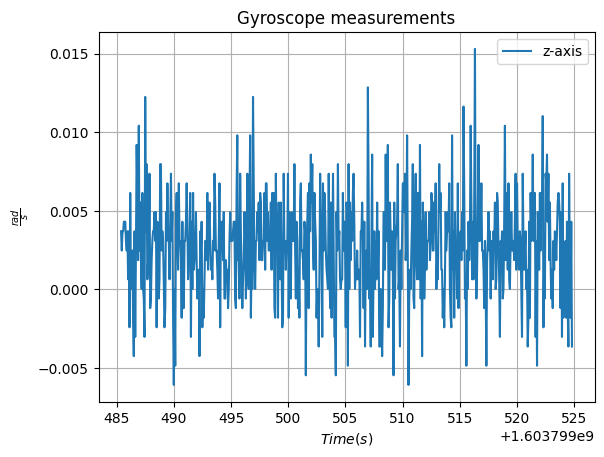

In [15]:

IMU_data_calibration = np.loadtxt('../data/task1/imu_reading_task1.csv',delimiter=',',dtype='double')
gyro_time_calibration = IMU_data_calibration[:,0]
gyro_z_calibration = IMU_data_calibration[:,8]*np.pi/180 # z-axis, to radians/s

gyro_z_bias = np.round(np.mean(gyro_z_calibration),4)
gyro_z_var = np.round(np.var(gyro_z_calibration),6)

Q = np.diag([speed_variance,speed_variance,gyro_z_var])

plt.figure()
plt.plot(gyro_time_calibration,gyro_z_calibration)
plt.title('Gyroscope measurements')
plt.xlabel('$Time (s)$')
plt.ylabel('$\\frac{rad}{s}$')
plt.legend(['z-axis'])
plt.grid()

print(f'Angular velocity bias: {gyro_z_bias}')
print(f'Angular velocity variance: {gyro_z_var}')

## Dead reckoning

### Loading data

In [16]:
motor_data = np.loadtxt('../data/task6-task7/motor_control_tracking_task6.csv', delimiter=',',dtype='float')
motor_time = motor_data[:,0]
motor_left = motor_data[:,1]
motor_right = motor_data[:,2]

IMU_data = np.loadtxt('../data/task6-task7/imu_tracking_task6.csv',delimiter=',',dtype='float')
gyro_time = IMU_data[:,0]
gyro_z = IMU_data[:,8]*np.pi/180 # to radians
gyro_z = gyro_z-gyro_z_bias # subtracting bias
robot_speed_estimates = (motor_left+motor_right)/2*speed_100 #averaged speed of both sides

### Model and estimation definitions

In [17]:
f_robot = lambda x,u: np.array( [u[0]*np.cos(x[2]), 
                                 u[0]*np.sin(x[2]), 
                                 u[1]] )

def Euler_method(func, u, x0, T):
    x = np.zeros((len(T),3))
    x[0] = x0
    for n in range(1, len(T)):
        dt = T[n] - T[n-1]
        x[n,:] = x[n-1,:] + func(x[n-1,:], u[n-1,:]) * dt
    return x

def dead_reconing_jacobian(x, u):
    jac = np.array([ [0, 0,  -u[0] * np.sin(x[2])], 
                     [0, 0,  u[0] * np.cos(x[2])], 
                     [0, 0,  0] ])
    return jac

def linearization_solution(f, jac, t, x0, u):
    x = np.zeros((t.shape[0],x0.shape[0]))
    I = np.eye(x0.shape[0])
    x[0] = x0
    for i in range(1,t.shape[0]):
        dt = t[i] - t[i-1]
        A = jac(x[i-1],u[i-1])
        F = (I + 0.5*A*dt + A@A*dt*dt/2) * dt  # this is an approximation
        x[i] = x[i-1] + F @ f(x[i-1],u[i-1])
    return x


### Combining speed and gyroscope data

Zero-order hold is used for the speed data since the sampling frequency of gyroscope is much higher. 

To make the data more accurate, an assumption was made that the wheels do not move backwards (confirmed from robot code). Therefore, we know that when both motors have the same input (the speed is the same for both sides), the angular frequency should be 0.

In [18]:
k = 0
u_robot = np.zeros((gyro_z.shape[0],2))
for i, speed in enumerate(robot_speed_estimates):

    motor_timestamp = motor_time[i]
    for j, ang_velocity in enumerate(gyro_z[k:-1]):
        gyro_timestamp = gyro_time[k+j]
        if(gyro_timestamp>motor_timestamp):
            k = k+j
            break

        u_robot[k+j,0] = speed
        u_robot[k+j,1] = 0 if (motor_left[i]== motor_right[i]) else ang_velocity
        # u_robot[k+j,1] = ang_velocity
    if (k >= (len(gyro_z)-1)):
        break

### Dead-reckoning solution

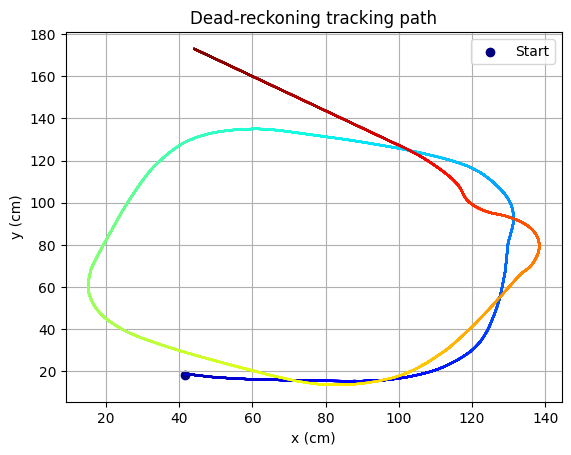

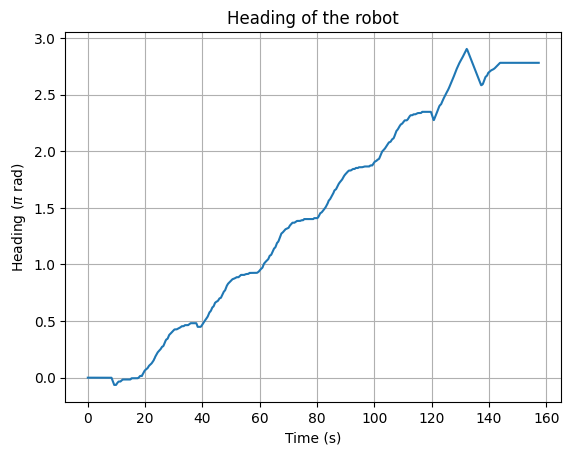

In [19]:

x_robot_0 = np.array([41.7,18.5,0])
# dead_reckoning = Euler_method(f_robot, u_robot, x_robot_0, gyro_time)
dead_reckoning = linearization_solution(f_robot,
                                  dead_reconing_jacobian, 
                                  gyro_time, 
                                  x_robot_0, 
                                  u_robot)


x = dead_reckoning[:,0]
y = dead_reckoning[:,1]

MAP = 'jet'
NPOINTS = len(x)

fig = plt.figure()
ax1 = fig.add_subplot(111) 
cm = plt.get_cmap(MAP)
for i in range(10):
    ax1.set_prop_cycle('color',[cm(1.0*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    for i in range(NPOINTS-1):
        plt.plot(x[i:i+2],y[i:i+2])
plt.title("Dead-reckoning tracking path")
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.scatter(x[0],y[0]).set_label('Start')
plt.legend()
plt.grid()

plt.figure()
plt.plot(gyro_time-gyro_time[0],dead_reckoning[:,2]/np.pi)
plt.title("Heading of the robot")
plt.xlabel("Time (s)")
plt.ylabel("Heading ($\\pi$ rad)")
plt.grid()



# Task 7

In [20]:
from modules.localization import Localization
from modules.qr_code import QrCode, Measurement


camera_columns = ['timestamp', 'qr_code', 'cx', 'cy', 'width', 'height', 'distance', 'attitude']
qr_df = pd.read_csv('../data/qr_code_position_in_global_coordinate.csv')
camera_df = pd.read_csv("../data/task5/camera_localization_task5.csv", header=None, names=camera_columns)
# Setting up required QR codes' data for the task

qr_codes = []
for index, row in qr_df.iterrows():
    qr = QrCode(int(row['qr_code']), row['mid_point_x_cm'], row['mid_point_y_cm'])
    qr_codes.append(qr)

for qr in qr_codes:
    for index, row in camera_df.iterrows():
        if row['qr_code'] == qr.id:
            qr.add_measurement(Measurement(row['timestamp'], row['cx'], row['height']))

for qr in qr_codes:
    if len(qr.measurements) <= 1:
        qr_codes.remove(qr)
    else:
        qr.compute_variance()
avg_variance_cx = np.round(np.mean([qr_code.var_cx for qr_code in qr_codes if qr_code.var_cx is not None] ), decimals=3) 
avg_variance_height = np.round(np.mean([qr_code.var_height for qr_code in qr_codes if qr_code.var_cx is not None]), decimals=3)
R = np.array([[avg_variance_height, 0], [0, avg_variance_cx]])
R_inv = np.array([[np.round(1/avg_variance_height, decimals=3), 0], [0, np.round(1/avg_variance_cx, decimals=3)]])


camera_df = pd.read_csv('../data/task6-task7/camera_tracking_task6.csv', header=None, names=camera_columns)


qr_codes = []

for index, row in qr_df.iterrows():
    qr = QrCode(int(row['qr_code']), row['mid_point_x_cm'], row['mid_point_y_cm'])
    qr_codes.append(qr)

y = []

timestamp = camera_df['timestamp'][0]
change_timestamp = False
current_qr_codes = []
localization_collection = []
for index, row in camera_df.iterrows():
    if row['timestamp'] == timestamp:
        for qr in qr_codes: 
            
            if row['qr_code'] == qr.id:
                qr.add_measurement(Measurement(row['timestamp'], row['cx'], row['height']))
                current_qr_codes.append(qr)
    else:
        localization = Localization(h0=11.5, path="../data/task3/camera_module_calibration_task3.csv", qr_codes=current_qr_codes, distance_bias=6.7)
        localization_collection.append(localization)
        current_qr_codes = []
        timestamp = row['timestamp']
        for qr in qr_codes: 
            
            if row['qr_code'] == qr.id:
                qr.add_measurement(Measurement(row['timestamp'], row['cx'], row['height']))
                current_qr_codes.append(qr)
    if index == len(camera_df)-1 and row['timestamp'] != timestamp:
        localization = Localization(h0=11.5, path="../data/task3/camera_module_calibration_task3.csv", qr_codes=current_qr_codes, distance_bias=6.7)
        localization_collection.append(localization)

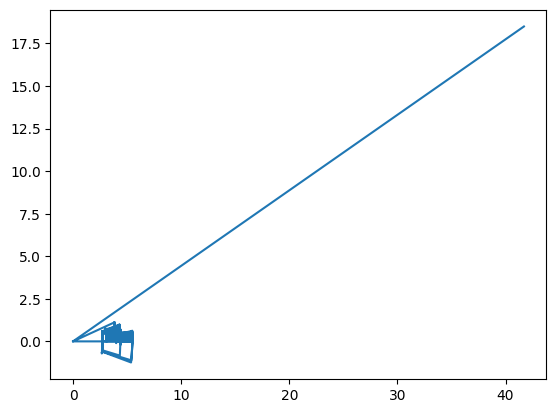

In [21]:
def Extended_Kalman_Filter_u(f, F, Q_, R, m0, P0, u, localizations, timestamps):
    T = u.shape[0]
    nx = m0.shape[0] # dimension of x
    x = np.zeros((T, nx))
    P = np.zeros((T, nx, nx))
    x[0] = m0
    P[0] = P0
    k = 0
    for n in range(T-1):
        # Prediction
        Q =  Q_*(timestamps[1]-timestamps[0]) if n==0 else Q_*(timestamps[n]-timestamps[n-1] )
        x_ = f(x[n], u[n])
        F_x = F(x[n], u[n])
        P_ = F_x @ P[n] @ F_x.T
        if(timestamps[n]>= localizations[k].qr_codes[0].measurements[0].timestamp):
            # print(timestamps[n])
            loc = localizations[k]
            k += 1
            [x_update, P_update] = loc.Kalman_update(x_, P_, R)    
            P[n+1] = P_update
            x[n+1] = x_update
        else:
            P[n+1] = P[n]
            x[n+1] = x_
        if len(localizations) == k:
            break
    return x, P
x,P=Extended_Kalman_Filter_u(f_robot,dead_reconing_jacobian,Q, R,x_robot_0,Q,u_robot,localization_collection,gyro_time )
plt.figure()
plt.plot(x[:,0],x[:,1])